## Wine quality

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. 

Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). 

Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

In [46]:
import pandas as pd
import numpy as np
import imblearn
from matplotlib import pyplot
from pathlib import Path
from collections import Counter
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.model_selection import train_test_split, KFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score

In [47]:
filepath_red = Path("../data/winequality-red.csv")
filepath_white = Path("../data/winequality-white.csv")
assert all([filepath_red.is_file(), filepath_white.is_file()])
dataset_red = pd.read_csv(filepath_red, sep=";").assign(red = 1)
dataset_white = pd.read_csv(filepath_white, sep=";").assign(white = 1)

In [48]:
# concatenate both dataset and create dummy variable
dataset  = pd.concat([dataset_red, dataset_white], sort=False).fillna(0)

In [49]:
# imbalanced class for predictor variable
dataset['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

### Validation Dataset

Using a hold-out set of data for validation post modeling. Smoke test to confirm accuracy and verify if we have messed up or not. 

In [50]:
# hold back data from analysis and modelling. 
array = dataset.values
names = dataset.columns.tolist()
X = array[:, 0:11]
y = array[:, 11]
validation_size = 0.20
seed = 7
X_train, X_hold_out, y_train, y_hold_out = train_test_split(X, y, test_size = validation_size, random_state = seed)

### Evaluate Algorithms: Baseline

Gut feel suggests regression algorithms like Linear Regression and ElasticNet may do well. It is also possible that decision
trees and even SVM may do well. I have no idea. Let's design our test harness. We will use
10-fold cross-validation. The dataset is not too small and this is a good standard test harness
configuration. We will evaluate algorithms using the Mean Squared Error (MSE) metric. MSE
will give a gross idea of how wrong all predictions are (0 is perfect).

In [51]:
### num_folds = 10
scoring = 'neg_mean_squared_error'

In [52]:
# suite of 6 algorithms to be used 3 linear and 3 non-linear
# all using the default tunning parameters
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR(gamma='auto')))

In [53]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(estimator=model, X=X_train, y=y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = f"{name}::{cv_results.mean()} (+/-) {cv_results.std()}"    
    print(msg)

LR::-0.5463503469332609 (+/-) 0.0403782428714399
LASSO::-0.7636008014822298 (+/-) 0.06232716234981276
EN::-0.7561166619013425 (+/-) 0.06240968442792947
KNN::-0.6435371572550763 (+/-) 0.053390220526676586
CART::-0.7092737512968728 (+/-) 0.07711947338681593
SVM::-0.5358858392890931 (+/-) 0.04924269855124872


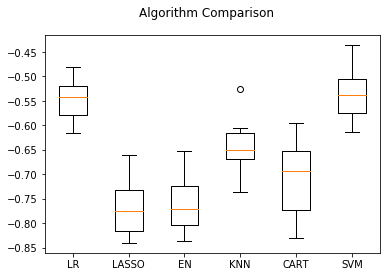

In [54]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

#### Evaluate Algorithms: Standardization


In [55]:
# Standadize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()), ('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()), ('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVR(gamma='auto'))])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(estimator=model, X=X_train, y=y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = f"{name}::{cv_results.mean()} (+/-) {cv_results.std()}"    
    print(msg)

ScaledLR::-0.5463503469332593 (+/-) 0.040378242871437896
ScaledLASSO::-0.7658250651012368 (+/-) 0.06185534759457455
ScaledEN::-0.7658250651012368 (+/-) 0.06185534759457455
ScaledKNN::-0.4920054394545724 (+/-) 0.03684061967390374
ScaledCART::-0.7171776345042241 (+/-) 0.10186942902314222
ScaledSVM::-0.46546106293892464 (+/-) 0.03640262007606245


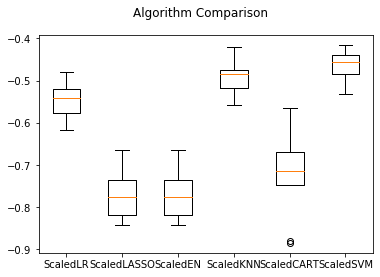

In [56]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

#### Finalize Model

In [ ]:
# prepare the data
best_params = {'n_neighbors': 7}
model = KNeighborsRegressor(**best_params)
model.fit(rescaledX, y_train)

# estimate accuracy on hold out set
rescaledHoldOutX = scaler.transform(X_hold_out)
predictions = model.predict(rescaledHoldOutX)

print(mean_squared_error(y_hold_out, predictions))

In [ ]:
pd.concat([pd.Series(predictions), pd.Series(y_hold_out)], axis=1).rename(columns = {0: 'predictions', 1:'y_val'}).sample(10)

In [ ]:
print(accuracy_score(y_true=y_hold_out, y_pred=predictions.round()))
print(confusion_matrix(y_true=y_hold_out, y_pred=predictions.round()))
print(classification_report(y_true=y_hold_out, y_pred=predictions.round()))